### Portfolio

# Learning of Structured Data

### – Sheet 3 –

This assignment was created by:
- Mark Erokhin (mark.erokhin@study.thws.de) - k68532;
- Anastasiia Demidova   (anastasiia.demidova@study.thws.de) - k67881.

## Exercise 1: (Data) Loading & Visualization

In [ ]:
#import nesessary liblraries:
import os
import csv
import random
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
path_train="./data/train"
path_test="./data/test"
valid_actions = {"boxing", "drums", "guitar", "rowing", "violin"}
keypoint_names = {
    "0": "Nose", 
    "1": "Neck", 
    "2": "RShoulder", 
    "3": "RElbow", 
    "4": "RWrist",
    "5": "LShoulder", 
    "6": "LElbow", 
    "7": "LWrist", 
    "8": "MidHip", 
    "9": "RHip",
    "10": "RKnee", 
    "11": "RAnkle", 
    "12": "LHip", 
    "13": "LKnee", 
    "14": "LAnkle",
    "15": "REye", 
    "16": "LEye", 
    "17": "REar", 
    "18": "LEar", 
    "19": "LBigToe",
    "20": "LSmallToe", 
    "21": "LHeel", 
    "22": "RBigToe", 
    "23": "RSmallToe", 
    "24": "RHeel"
}
angle_names = ["R_Elbow_Angle", "R_Armpit_Angle", "L_Elbow_Angle", "L_Armpit_Angle"]

In [ ]:
# class initialization:

class Dataset:
    def __init__(self, path_train, path_test):
        self.data = {"train": {}, "test": {}} # store data in a dictionary
        self._load_data(path_train, "train") # load train data
        self._load_data(path_test, "test") # load test data
        
    # loads the .csv files in data/train/ and data/test/:
    def _load_data(self, directory, dataset_type):
        for file_name in os.listdir(directory): # use listdir to get filenames in nesessary folder
            if file_name.endswith(".csv"): # take files only with .csv extantion
                subject, action, iteration = self._parse_file_name(file_name) # to split the file name into subject, action, and iteration
                if action not in valid_actions: # check that isn't used invalid action
                    raise ValueError(f"Invalid action '{action}' in file '{file_name}'. Allowed actions: {valid_actions}")

                file_path = os.path.join(directory, file_name) # create the path to the nesessary file
                sequence = self._load_csv(file_path) # load data to get nesessary sequence

            # add sequence into the data dictionary:
                if subject not in self.data[dataset_type]:
                    self.data[dataset_type][subject] = {}
                if action not in self.data[dataset_type][subject]:
                    self.data[dataset_type][subject][action] = {}

                self.data[dataset_type][subject][action][iteration] = sequence

    # get subject, action, and iteration using filename:
    def _parse_file_name(self, file_name):
        base_name = file_name.rsplit(".", 1)[0] # get name before .csv
        subject, action, iteration = base_name.split("_") # split remaining filename into  subject, action, and iteration
        return subject, action, iteration

    # read nesessary file row by row:
    def _load_csv(self, file_path):
        sequence = []
        with open(file_path, "r") as f:
            reader = csv.reader(f)
            for row in reader:
                sequence.append([float(value) for value in row])
        return sequence
    
    # create column names to dislay:
    def get_column_names(self):
            columns = []
            for i in range(len(keypoint_names)):
                keypoint = keypoint_names[str(i)]
                columns.extend([f"X {keypoint}", f"Y {keypoint}", f"C {keypoint}"])
            columns.extend(angle_names) 
            return columns
    
    # ensure all numbers have the same format to display:
    def format_sequence(self, seq):
        formatted_seq = []
        for row in seq:
            formatted_row = [f"{value:.6e}" for value in row]
            formatted_seq.append(formatted_row)
        return formatted_seq
    
# two main functions:
    # – getSequence(self, dataset, subject, action, iteration): returns a
    # tuple (seq,label), where seq contains the specified sequence (iteration i of
    # action j by subject k in dataset ‘train’ or ‘test’) and label the associated
    # label.
    
    # – random(self, dataset): returns a random tuple (seq,label) from
    # dataset (‘train’ or ‘test’), where seq contains a sequence and label the
    # associated label.
    def getSequence(self, dataset, subject, action, iteration):
        try: # run this code until an error occur
            seq = self.data[dataset][subject][action][iteration] # get sequence from data dictionary
            label = f"{subject}_{action}_{iteration}.csv" # get label - file name 
            columns = self.get_column_names() # get column names
            formatted_seq = self.format_sequence(seq) # format data (use only for visualisation)
            return seq, label, columns, formatted_seq
        except KeyError:
            raise ValueError(f"Sequence not found for {dataset}/{subject}_{action}_{iteration}.csv")

    def random(self, dataset):
        try: # run this code until an error occur
            subject = random.choice(list(self.data[dataset].keys())) # list converts the dictionary keys into a list, where keys - ["p0", "p1", ...]
            action = random.choice(list(self.data[dataset][subject].keys()))
            iteration = random.choice(list(self.data[dataset][subject][action].keys()))
            return self.getSequence(dataset, subject, action, iteration)
        except IndexError:
            raise ValueError(f"No data available in {dataset} dataset")
        
# Visualization ------------------------------------------------------------------------------------------ 
    # – visualize(self, dataset, subject, action, iteration, frame)
    # that saves a visual representation of the specified frame to disk.
    # Save the 125 frame visualizations corresponding to file “p0_boxing_01.csv” to disk
    # and convert the individual frames into an .mp4 video (frame rate: 30 frames per second).
    def visualize(self, dataset, subject, action, iteration, frame, output_dir="visualizations"):
        seq, _, _, _ = self.getSequence(dataset, subject, action, iteration)
        frame_data = seq[frame]

        # has_angles = len(frame_data) >= 79

        x_coords = frame_data[::3][:25]  # first 25 keypoints (X)
        y_coords = frame_data[1::3][:25]  # first 25 keypoints (Y)
        confidences = frame_data[2::3][:25]  # first 25 keypoints (C)

        # skeleton connections
        skeleton = [
            (0, 1),    # Nose to Neck
            (1, 2),    # Neck to RShoulder
            (2, 3),    # RShoulder to RElbow
            (3, 4),    # RElbow to RWrist
            (1, 5),    # Neck to LShoulder
            (5, 6),    # LShoulder to LElbow
            (6, 7),    # LElbow to LWrist
            (1, 8),    # Neck to MidHip
            (8, 9),    # MidHip to RHip
            (9, 10),   # RHip to RKnee
            (10, 11),  # RKnee to RAnkle
            (8, 12),   # MidHip to LHip
            (12, 13),  # LHip to LKnee
            (13, 14),  # LKnee to LAnkle
            (15, 16),  # REye to LEye
            (15, 17),  # REye to REar
            (16, 18),  # LEye to LEar
            (9, 19),   # RHip to LBigToe
            (19, 20),  # LBigToe to LSmallToe
            (20, 21),  # LSmallToe to LHeel
            (10, 22),  # RKnee to RBigToe
            (22, 23),  # RBigToe to RSmallToe
            (23, 24) 
        ]
 
        num_joints = 25
        colors = [plt.cm.jet(i / num_joints) for i in range(num_joints)] # set up colors for Visualization
       

        # draw skeleton connections:
        for joint1, joint2 in skeleton:
            connection_index = (joint1 + joint2) % len(colors)  # cycle through colors
            if confidences[joint1] > 0.5 and confidences[joint2] > 0.5: # check confidences. draw only those that are more than 0.5
                plt.plot(
                    [x_coords[joint1], x_coords[joint2]],
                    [y_coords[joint1], y_coords[joint2]],
                    color=colors[connection_index],
                    linewidth=3
                )

        # scatter keypoints
        plt.scatter(x_coords, y_coords, c=confidences, cmap="plasma", s=[50 * conf for conf in confidences]) # vary the size of the markers based on confidences

        # annotate keypoints
        for i, name in keypoint_names.items():
            idx = int(i)
            plt.text(x_coords[idx], y_coords[idx], name, fontsize=6, ha="right", va="bottom")

         # Display angles if available
        # if has_angles:
        #     angles = frame_data[-4:]
        #     for i, angle_name in enumerate(angle_names):
        #         plt.text(0.1, 0.9 - 0.05 * i, f"{angle_name}: {angles[i]:.2f}°", transform=plt.gca().transAxes, fontsize=10, color="white")
                
        plt.gca().invert_yaxis() # reverses the direction of the Y-axis
        plt.title(f"{subject} - {action} - Iteration {iteration} - Frame {frame}")
        plt.axis("equal")

        os.makedirs(output_dir, exist_ok=True) # create directory
        output_path = os.path.join(output_dir, f"{subject}_{action}_{iteration}_frame_{frame}.png") # create output path name
        plt.savefig(output_path) # save frame in output path
        plt.close()

    # to join all (125) frames to crate and save a video:
    def save_video(self, dataset, subject, action, iteration, output_video="output.mp4", frame_rate=30):
        output_dir = f"frames {subject}_{action}_{iteration}" # create output directory file name
        os.makedirs(output_dir, exist_ok=True) # create directory

        seq, _, _, _ = self.getSequence(dataset, subject, action, iteration)

        frame_limit = 125  # limit the number of frames to save
        for frame in range(min(frame_limit, len(seq))):  # Limit to 125 or the sequence length, whichever is smaller
            self.visualize(dataset, subject, action, iteration, frame, output_dir=output_dir)
            
        # to execute an FFmpeg command that converts a sequence of images into a video:
        subprocess.run([
            r"E:\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe", # executable path in my disk E
            "-y",           # overwrites the output file if it already exists
            "-framerate", str(frame_rate), # set up frame rate: 30 frames per second
            "-i", os.path.join(output_dir, f"{subject}_{action}_{iteration}_frame_%d.png"), # crate a file path
            "-vf",          # video filter
            "scale=640:480",# video resolution of 640x480 pixels
            "-c:v",         # for video compression
            "libx264",      # codec for encoding H.264 videos
            "-pix_fmt", "yuv420p", # pixel format
            output_video    # name (and path) of the output video file
        ])


        



    First of all, we store train and test datasets in the dictionary.

    We also noticed that datasets have weird parameters for parts below hips. and confidences for these parts are also equel 0, so in our class we visualize only confident keypoints and joints (above or equel 0). However in the output video and in frames you can see text for these points. We want you to know that we show the text, but we skipped keypoints below 0.5 and don't join them

In [ ]:

if __name__ == "__main__":
    dataset = Dataset(path_train, path_test) # get dataset from Dataset class
    seq, label, columns, formatted_seq = dataset.getSequence("train", "p0", "boxing", "01")
    df = pd.DataFrame(formatted_seq, columns=columns) # convert the data to a pandas DataFrame
    df = df.fillna("") # replace "none" with empty
    table_title = f"<h2>Sequence Label: {label}</h2>"  # add a title using custom HTML
    display(HTML(table_title))
    display(df)
    
    # do the same but for the random example:
    random_seq, random_label, columns, formatted_rand_seq = dataset.random("train")
    df = pd.DataFrame(formatted_rand_seq, columns=columns)
    df = df.fillna("")
    table_title_random = f"<h2>Random Sequence Label: {random_label}</h2>"
    display(HTML(table_title_random))
    display(df)


In [ ]:
# Save the 125 frame visualizations corresponding to file “p0_boxing_01.csv” to disk and convert 
# the individual frames into an .mp4 video (frame rate: 30 frames per second)
dataset.save_video("train", "p0", "boxing", "01", output_video="p0_boxing_01.mp4")

# One more video example:
# dataset.save_video("train", "p1", "guitar", "10", output_video="p1_guitar_10.mp4")


### Data visualization using different plots and parameters

#### 1. Distribution of Keypoint Confidences
**?Why?**  Show the distribution of confidence values for keypoints across all frames in the sequence using a histogram plot.

As the result we can see that the most frequently confidences are about 0 and 1. In previous steps (in video visualization) we skipped all confidences less than 0.5

In [ ]:
# Extract confidence values for all keypoints across frames
all_confidences = [frame[2::3] for frame in seq]  # Extract all confidence values (C) from seq
all_confidences = [value for sublist in all_confidences for value in sublist]  # Flatten the list

plt.figure(figsize=(10, 6))
sns.histplot(all_confidences, bins=20, kde=True, color="blue")
plt.title("Distribution of Keypoint Confidences")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()


#### 2. Heatmap of Keypoint Activit

**?Why?** Visualize the density of keypoint activity over a grid using a 2D heatmap for keypoint positions.

As the result we can see how many incorrect keypoints are in our datasets especially those that have 0 confidence (parts below hips)

In [ ]:
# first we filter out columns with angles to match the sizes of x and y
filtered_plot_seq = [frame for frame in seq if len(frame) % 3 == 0]
# Extract X and Y coordinates for all keypoints across frames in the sequence
all_x_coords = [frame[::3] for frame in filtered_plot_seq]  # Extract all X coordinates
all_y_coords = [frame[1::3] for frame in filtered_plot_seq]  # Extract all Y coordinates

# Flatten the lists
all_x_coords = [value for sublist in all_x_coords for value in sublist]
all_y_coords = [value for sublist in all_y_coords for value in sublist]

# Check if lengths match
assert len(all_x_coords) == len(all_y_coords), "Mismatch between X and Y coordinates!"

# Create 2D histograms of all keypoint positions
plt.figure(figsize=(10, 8))
sns.kdeplot(x=all_x_coords, y=all_y_coords, cmap="Reds", fill=True, bw_adjust=0.5)
plt.title("Heatmap of Keypoint Activity")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.gca().invert_yaxis()
plt.show()


#### 3. Scatter Plots for Keypoints
**?Why?** Show spatial distribution of keypoints plotting all keypoint positions across frames

Has quite the similar purpose as Heatmap plot, but here we can see keypoints distribution


In [ ]:

plt.figure(figsize=(10, 10))
plt.scatter(all_x_coords, all_y_coords, alpha=0.5, color="purple")
plt.title("Scatter Plot of Keypoint Positions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.gca().invert_yaxis()  # Invert Y-axis for visual consistency
plt.show()



## Exercise 2: (Model) Design and Evaluation

### Exercise 2.1 (Design):

Preprocess the data:

*– do you need to remove outliers from the training set?*

    Yes, we need because datasets contain some mistakes (parts with zero confidence scores), these should be removed.

    **However**, the train dataset contains the same mistakes which we are not allowed to remove, so we didn't remove 0 confidences from the train dataset.

*– do you need to perform normalization on the training/test set?*

    Yes, we need normalization for our datasets with keypoint coordinates.

Classes: ['boxing' 'drums' 'guitar' 'rowing' 'violin']
Run 1/5
Classification Report:
              precision    recall  f1-score   support

      boxing       0.77      0.88      0.82        60
       drums       0.88      0.73      0.80        62
      guitar       0.94      0.84      0.89        61
      rowing       0.93      0.92      0.93        61
      violin       0.85      0.98      0.91        61

    accuracy                           0.87       305
   macro avg       0.87      0.87      0.87       305
weighted avg       0.88      0.87      0.87       305



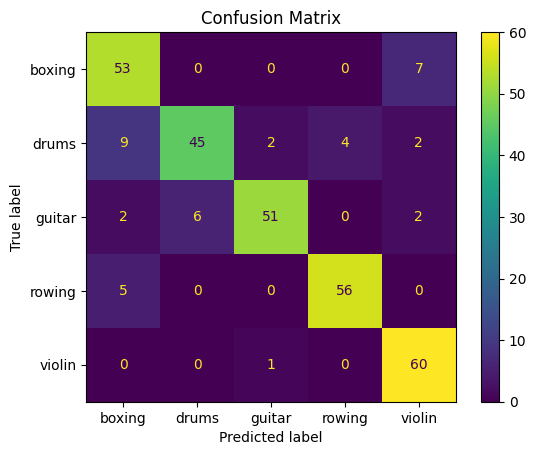

Run 1 Accuracy: 0.8689
Mean Accuracy: 0.8689 ± 0.0000
Run 2/5
Classification Report:
              precision    recall  f1-score   support

      boxing       0.83      0.87      0.85        60
       drums       0.88      0.71      0.79        62
      guitar       0.88      0.82      0.85        61
      rowing       0.95      0.97      0.96        61
      violin       0.82      0.98      0.90        61

    accuracy                           0.87       305
   macro avg       0.87      0.87      0.87       305
weighted avg       0.87      0.87      0.87       305



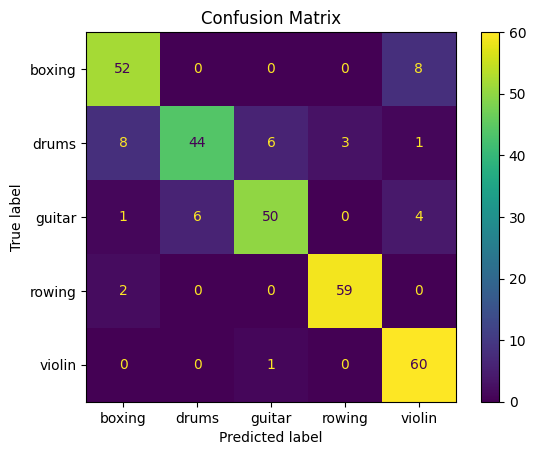

Run 2 Accuracy: 0.8689
Mean Accuracy: 0.8689 ± 0.0000
Run 3/5
Classification Report:
              precision    recall  f1-score   support

      boxing       0.84      0.87      0.85        60
       drums       0.87      0.73      0.79        62
      guitar       0.94      0.79      0.86        61
      rowing       0.95      0.98      0.97        61
      violin       0.79      1.00      0.88        61

    accuracy                           0.87       305
   macro avg       0.88      0.87      0.87       305
weighted avg       0.88      0.87      0.87       305



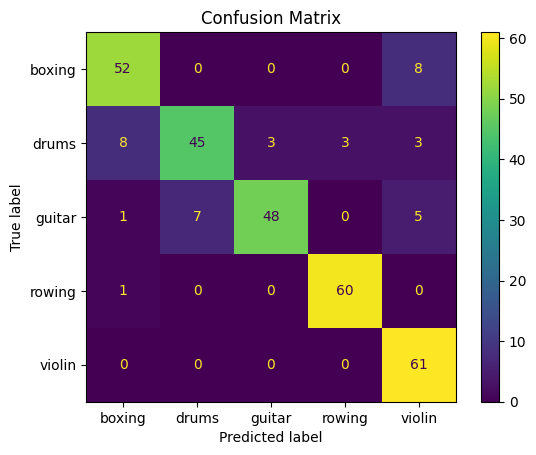

Run 3 Accuracy: 0.8721
Mean Accuracy: 0.8699 ± 0.0015
Run 4/5
Classification Report:
              precision    recall  f1-score   support

      boxing       0.83      0.87      0.85        60
       drums       0.88      0.71      0.79        62
      guitar       0.93      0.87      0.90        61
      rowing       0.94      0.98      0.96        61
      violin       0.85      0.98      0.91        61

    accuracy                           0.88       305
   macro avg       0.88      0.88      0.88       305
weighted avg       0.88      0.88      0.88       305



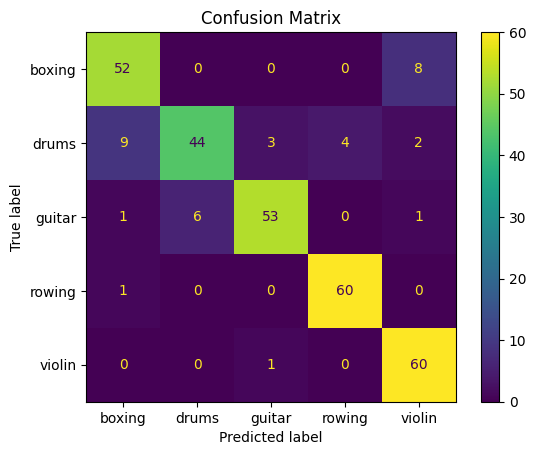

Run 4 Accuracy: 0.8820
Mean Accuracy: 0.8730 ± 0.0054
Run 5/5
Classification Report:
              precision    recall  f1-score   support

      boxing       0.81      0.87      0.84        60
       drums       0.85      0.74      0.79        62
      guitar       0.98      0.79      0.87        61
      rowing       0.92      1.00      0.96        61
      violin       0.83      0.98      0.90        61

    accuracy                           0.88       305
   macro avg       0.88      0.88      0.87       305
weighted avg       0.88      0.88      0.87       305



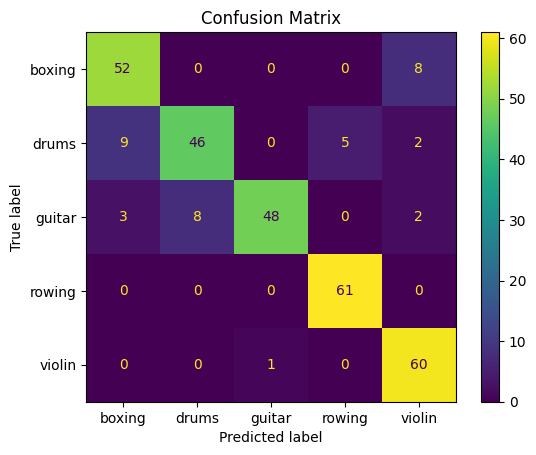

Run 5 Accuracy: 0.8754
Mean Accuracy: 0.8734 ± 0.0049


In [24]:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

class MotionDataset:
    def __init__(self, train_dir="data/train", test_dir="data/test"):
        self.train_data = []
        self.train_labels = []
        self.test_data = []
        self.test_labels = []
        self.valid_actions = {"boxing", "drums", "guitar", "rowing", "violin"}
        self._load_data(train_dir, "train")
        self._load_data(test_dir, "test")

    def _load_data(self, directory, dataset_type):
        for file_name in os.listdir(directory):
            if file_name.endswith(".csv"):
                subject, action, iteration = self._parse_file_name(file_name)
                if action not in self.valid_actions:
                    continue

                file_path = os.path.join(directory, file_name)
                sequence = self._load_csv(file_path)

                features = self._extract_features(sequence)
                if dataset_type == "train":
                    self.train_data.append(features)
                    self.train_labels.append(action)
                elif dataset_type == "test":
                    self.test_data.append(features)
                    self.test_labels.append(action)

    def _parse_file_name(self, file_name):
        base_name = file_name.rsplit(".", 1)[0]
        subject, action, iteration = base_name.split("_")
        return subject, action, int(iteration)

    def _load_csv(self, file_path):
        rows = []
        with open(file_path, "r") as f:
            for line in f:
                values = line.strip().split(",")
                if len(values) > 75:
                    values = values[:75]  # Trim extra columns
                elif len(values) < 75:
                    values.extend(["0.0"] * (75 - len(values)))  # Pad missing columns with zeros
                rows.append([float(value) for value in values])
        return np.array(rows)

    def _extract_features(self, sequence):
        x_coords = sequence[:, ::3]
        y_coords = sequence[:, 1::3]
        confidences = sequence[:, 2::3]

        features = []
        features.extend(np.mean(x_coords, axis=0))
        features.extend(np.mean(y_coords, axis=0))
        features.extend(np.std(x_coords, axis=0))
        features.extend(np.std(y_coords, axis=0))
        features.extend(np.mean(confidences, axis=0))

        return np.array(features)

    def get_train_test_data(self):
        return (
            np.array(self.train_data),
            np.array(self.train_labels),
            np.array(self.test_data),
            np.array(self.test_labels),
        )

def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

def train_and_evaluate(X_train, y_train, X_test, y_test, label_encoder):
    model = RandomForestClassifier(
        n_estimators=300,            # Increase number of trees
        max_depth=30,                # Allow deeper trees
        min_samples_split=5,         # Require more samples to split
        min_samples_leaf=2,          # Require more samples per leaf
        max_features='sqrt',         # Use square root of features
        random_state=random.randint(0, 10000)  # Random seed for reproducibility
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_).plot()
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy_score(y_test, y_pred)

def run_experiments(X_train, y_train, X_test, y_test, label_encoder, num_runs=5):
    accuracies = []

    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs}")

        # Set random seed for reproducibility
        set_random_seed(run)

        # Train and evaluate
        accuracy = train_and_evaluate(X_train, y_train, X_test, y_test, label_encoder)
        accuracies.append(accuracy)

        mean_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)

        print(f"Run {run + 1} Accuracy: {accuracy:.4f}")
        print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

    return accuracies

if __name__ == "__main__":
    # Load dataset
    dataset = MotionDataset(train_dir="data/train", test_dir="data/test")
    X_train, y_train, X_test, y_test = dataset.get_train_test_data()

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    print("Classes:", label_encoder.classes_)

    # Run experiments and evaluate
    run_experiments(X_train, y_train, X_test, y_test, label_encoder)


In [17]:
dataset = MotionDataset(train_dir="data/train", test_dir="data/test")

# Check the shape of the processed training and test data
X_train, y_train, X_test, y_test = dataset.get_train_test_data()
print("Train Data Shape:", X_train.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Labels Shape:", y_test.shape)

Train Data Shape: (1167, 125)
Train Labels Shape: (1167,)
Test Data Shape: (305, 125)
Test Labels Shape: (305,)
